第3章 追跡アルゴリズム
==

In [1]:
from matplotlib.font_manager import FontProperties

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

In [2]:
# 数値例
class NumericalExample(object):
    def __init__(self, n, m, k):
        """ 
        n 行数
        m 列数
        k 非ゼロの要素数 
        A 冗長なシステム行列 mxn
        x スパースな解 m
        b 観測 n
        S サポート m
        """
        # 冗長なシステム行列A
        self.A = (np.random.rand(n, m) - 0.5) * 2
        self.A = np.dot(self.A, np.diag(1. / np.sqrt(np.diag(np.dot(self.A.T, self.A)))))    
        
        #　スパースなx
        self.x = np.zeros(m)
        ndx = np.random.randint(0, m - 1, k)
        for i in ndx:
            self.x[i] = np.random.rand() + 1.
            if np.random.rand() < 0.5:
                self.x[i] *= -1.

        # 観測n
        self.b = np.dot(self.A, self.x)
        
        # サポートS
        self.S = np.zeros(m, dtype=np.uint8)
        self.S[ndx] = 1

In [3]:
# 貪欲アルゴリズム
class Greedy(object):
    def __init__(self, A, b, eps=1e-4):
        """
        A m×n行列
        b n要素の観測
        eps 誤差の閾値
        """
        self.A = A
        self.b = b
        self.eps = eps

    def OMP(self):
        """ 直交マッチング追跡(orthogonal matching pursuit; OMP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(self.A.shape[1]):
            # 誤差計算
            err = rr - np.dot(self.A[:, S == 0].T, r) ** 2
            
            # サポート更新
            ndx = np.where(S == 0)[0]
            S[ndx[err.argmin()]] = 1
    
            # 解更新
            As = self.A[:, S == 1]
            pinv = np.linalg.pinv(np.dot(As, As.T))
            x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
            # 残差更新
            r = self.b - np.dot(self.A, x)
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S
    
    def MP(self):
        """ マッチング追跡(matching pursuit; MP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(1000):
            # 誤差計算
            err = rr - np.dot(self.A.T, r) ** 2

            # サポート更新
            j = err.argmin()
            S[j] = 1
    
            # 解更新
            a = self.A[:, j]
            z = np.dot(a, r)
            x[j] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def WMP(self, t=0.5):
        """ 
        弱マッチング追跡(weak matching pursuit; WMP)     
        t スカラー(0<t<1)
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in xrange(1000):
            # 誤差計算
            max_zz = 0
            j0 = 0
            for j in xrange(self.A.shape[1]):
                a = self.A[:, j]
                z = np.dot(a, r)
                if np.abs(z) > t * np.sqrt(rr):
                    j0 = j
                    break
                if z ** 2 > max_zz:
                    max_zz = z ** 2
                    j0 = j 
    
            # サポート更新
            S[j0] = 1
    
            # 解更新
            a = self.A[:, j0]
            z = np.dot(a, r)
            x[j0] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def Threshold(self, k):
        """ 
        閾値アルゴリズム(thresholding algorithm) 
        k 列の個数
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)

        # 誤差計算
        err = rr - np.dot(self.A.T, r) ** 2

        # サポートの更新
        ndx = np.argsort(err)[:k]
        S[ndx] = 1
        
        # 解更新
        As = self.A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
        return x, S

In [4]:
# 凸緩和アルゴリズム
class ConvexRelaxation(object):
    def __init__(self, A, b, eps=1e-20, iter=1000):
        """
        A m×n行列
        b n要素の観測
        eps 誤差の閾値
        """
        self.A = A
        self.b = b
        self.eps = eps
        self.iter = iter

    def IRLS(self, p=1):
        """ 
        反復重み付け最小二乗(iterative-reweighted-least-squares; IRLS) 
        p Lpノルム
        """
        # 初期化
        x = np.ones(self.A.shape[1])
        w = np.diag(np.ones(self.A.shape[1]))
        for _ in xrange(self.iter):
            x_prev = x.copy()
            awa = np.dot(self.A, np.dot(w ** 2, self.A.T))
            pinv = np.linalg.pinv(awa)
            x = np.dot(w ** 2, np.dot(self.A.T, np.dot(pinv, self.b)))
            w = np.diag(np.abs(x) ** (1 - p / 2))
            if np.sum(np.abs(x - x_prev)) < self.eps:
                break
        
        # サポート
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        S[np.abs(x) > 0] = 1

        return x, S

In [5]:
def l2_err(x, x2):
    return np.dot(x - x2, x - x2) / np.dot(x, x)

def dist_S(S, S2):
    val = max(np.sum(S), np.sum(S2))
    return float(val - np.sum(S * S2)) / val

n_iter = 200
n_base = 10
mean_l2_err = np.zeros((n_base, 5))
mean_dist_S = np.zeros((n_base, 5))
results = []
for k in xrange(1, n_base + 1):
    for _ in xrange(n_iter):
        # 数値例作成
        ne = NumericalExample(30, 50, k)
        
        # 貪欲法による解
        greedy = Greedy(ne.A, ne.b)
        x_OMP, S_OMP = greedy.OMP()
        x_MP, S_MP = greedy.MP()
        x_WMP, S_WMP = greedy.WMP(t=0.5)
        x_T, S_T = greedy.Threshold(k)

        # 凸緩和による解
        cr = ConvexRelaxation(ne.A, ne.b)
        x_IRLS, S_IRLS = cr.IRLS()

        # l2誤差計算
        for i, x2 in enumerate([x_OMP, x_MP, x_WMP, x_T, x_IRLS]): 
            mean_l2_err[k - 1, i] += l2_err(ne.x, x2)
        
        # サポート間距離計算
        for i, S2 in enumerate([S_OMP, S_MP, S_WMP, S_T, S_IRLS]): 
            mean_dist_S[k - 1, i] += dist_S(ne.S, S2)

    results.append([ne.x, x_OMP, x_MP, x_WMP, x_T, x_IRLS])        
    mean_l2_err[k - 1] /= n_iter
    mean_dist_S[k - 1] /= n_iter
    print k, mean_l2_err[k - 1]

1 [  1.15644872e-31   5.77897944e-32   1.48649252e-03   1.25195718e-31
   1.46904980e-31]
2 [  1.85895346e-31   6.26466840e-06   9.88664266e-03   4.76167186e-02
   2.03187303e-31]
3 [  1.03741815e-30   9.65468170e-06   1.23346865e-02   1.54576647e-01
   2.86108864e-30]
4 [  8.94856538e-03   1.45123059e-02   3.31605575e-02   2.31654465e-01
   1.89645946e-30]
5 [ 0.02121257  0.0449199   0.09209299  0.32268597  0.00365826]
6 [  4.28856331e-02   7.83866998e-02   1.05169341e-01   3.70270464e-01
   1.37211454e-30]
7 [ 0.10163493  0.17953911  0.21854542  0.42773465  0.00725289]
8 [ 0.17017102  0.28339473  0.28123111  0.46091365  0.01614949]
9 [ 0.26786664  0.32711229  0.31553658  0.49229436  0.02640609]
10 [ 0.34226121  0.39737659  0.39490019  0.5196874   0.04360418]


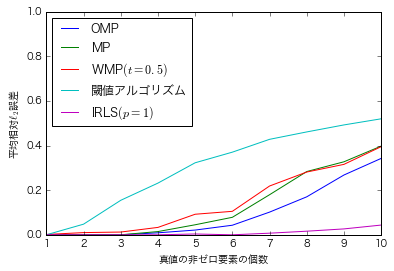

In [27]:
plt.plot(mean_l2_err[:, 0], label='OMP')
plt.plot(mean_l2_err[:, 1], label='MP')
plt.plot(mean_l2_err[:, 2], label='WMP$(t=0.5)$')
plt.plot(mean_l2_err[:, 3], label=u'閾値アルゴリズム')
plt.plot(mean_l2_err[:, 4], label='IRLS$(p=1)$')
plt.legend(loc='upper left')
plt.ylabel(u'平均相対$\ell_2$誤差')
plt.xlabel(u'真値の非ゼロ要素の個数')
plt.xticks(range(10), range(1, 11))
plt.ylim(0, 1)
plt.savefig('l2_err.png', dpi=220)

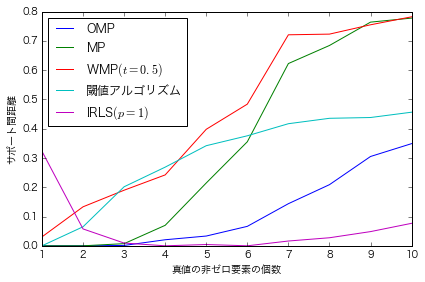

In [26]:
plt.plot(mean_dist_S[:, 0], label='OMP')
plt.plot(mean_dist_S[:, 1], label='MP')
plt.plot(mean_dist_S[:, 2], label='WMP$(t=0.5)$')
plt.plot(mean_dist_S[:, 3], label=u'閾値アルゴリズム')
plt.plot(mean_dist_S[:, 4], label=u'IRLS$(p=1)$')
plt.legend(loc='upper left')
plt.ylabel(u'サポート間距離')
plt.xlabel(u'真値の非ゼロ要素の個数')
plt.xticks(range(10), range(1, 11))
plt.tight_layout()
plt.savefig('dist_S.png', dpi=220)

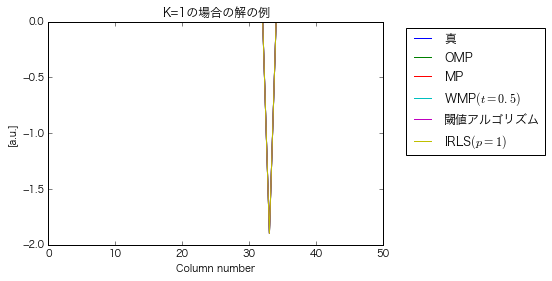

In [23]:
k=1
plt.plot(results[k - 1][0], label=u'真')
plt.plot(results[k - 1][1], label='OMP')
plt.plot(results[k - 1][2], label='MP')
plt.plot(results[k - 1][3], label='WMP$(t=0.5)$')
plt.plot(results[k - 1][4], label=u'閾値アルゴリズム')
plt.plot(results[k - 1][5], label=u'IRLS$(p=1)$')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Column number')
plt.ylabel('[a.u.]')
plt.title(u'K={}の場合の解の例'.format(k))
plt.savefig('X_{}.png'.format(k), dpi=220, bbox_extra_artists=(lgd,), bbox_inches='tight')

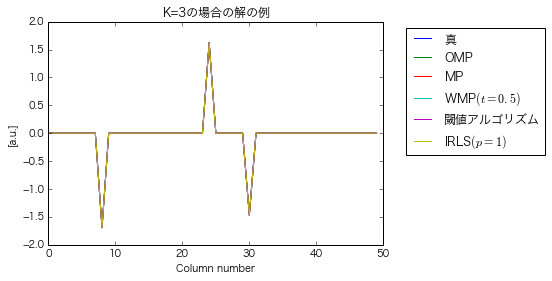

In [28]:
k=3
plt.plot(results[k - 1][0], label=u'真')
plt.plot(results[k - 1][1], label='OMP')
plt.plot(results[k - 1][2], label='MP')
plt.plot(results[k - 1][3], label='WMP$(t=0.5)$')
plt.plot(results[k - 1][4], label=u'閾値アルゴリズム')
plt.plot(results[k - 1][5], label=u'IRLS$(p=1)$')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Column number')
plt.ylabel('[a.u.]')
plt.title(u'K={}の場合の解の例'.format(k))
plt.savefig('X_{}.png'.format(k), dpi=220, bbox_extra_artists=(lgd,), bbox_inches='tight')

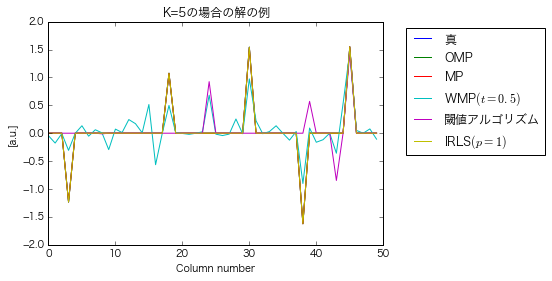

In [29]:
k=5
plt.plot(results[k - 1][0], label=u'真')
plt.plot(results[k - 1][1], label='OMP')
plt.plot(results[k - 1][2], label='MP')
plt.plot(results[k - 1][3], label='WMP$(t=0.5)$')
plt.plot(results[k - 1][4], label=u'閾値アルゴリズム')
plt.plot(results[k - 1][5], label=u'IRLS$(p=1)$')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Column number')
plt.ylabel('[a.u.]')
plt.title(u'K={}の場合の解の例'.format(k))
plt.savefig('X_{}.png'.format(k), dpi=220, bbox_extra_artists=(lgd,), bbox_inches='tight')

参考
--
Michael Elad（著），玉木徹（訳），スパースモデリング $\ell_{1}/\ell_{2}$ノルム最小化の基礎理論と画像処理への応用，http://www.kyoritsu-pub.co.jp/bookdetail/9784320123946